In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

import sscCdi
sscCdi.__version__, sscCdi.__path__

('0.8.10',
 ['/ibira/lnls/labs/tepui/home/yuri.tonin/.local/lib/python3.9/site-packages/sscCdi'])

In [2]:
z1 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/z_positions.npy')
z1 = z1[-1]*1e-3
z2 = 1 - z1
M = (z2+z1)/z1

z1, z2, M

(0.004278062, 0.995721938, 233.75070300523927)

In [3]:
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
}

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')

DPs0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/data.npy')
DPs0.shape
DPs=DPs0

Object pixel = 6.16040928e-09 m


In [4]:
positions = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/positions.npy')
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')

Probe shape = (2048, 2048)
[array([-2.022398, -2.022291])]
[array([-2.022398, -2.022291]), array([-2.022394, -2.022276])]
Size of the array: 12.8125 GB
Object shape = (22538, 22051)
Data shape = (1640, 2048, 2048)
Positions shape = (4, 2)


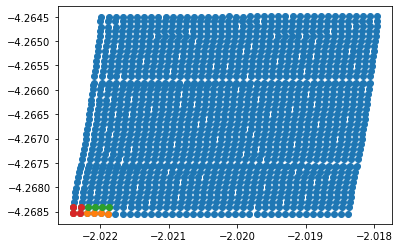

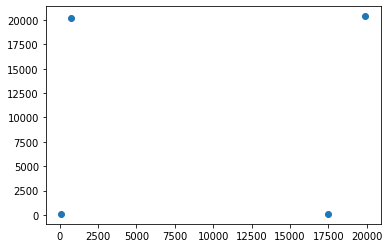

In [5]:
probe = np.ones_like(empty)

print(f'Probe shape = {probe.shape}')

N = 40
fig, ax = plt.subplots()
ax.plot(positions[:,1],positions[:,0],'o')
ax.plot(positions[0:6,1],positions[0:6,0],'o')
ax.plot(positions[N:6+N,1],positions[N:N+6,0],'o')

positions_x = []
positions_y = []
for i in range(0,2):
    A = N*i
    positions_x.append(positions[A:2+A,1])
    positions_y.append(positions[A:2+A,0])
    print(positions_x)

positions_x = np.asarray(positions_x).flatten()
positions_y = np.asarray(positions_y).flatten()
ax.plot(positions_x,positions_y,'o')
positions = np.vstack((np.asarray(positions_y),np.asarray(positions_x))).T

inputs["object_padding"] = 100
positions = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

fig, ax = plt.subplots()
ax.plot(positions[:,1],positions[:,0],'o')

if 0: # remove random points from data
    n_of_points_to_keep = 100
    start_idx = positions0.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions0.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs0,slices_to_ignore,axis=0)
    positions = np.delete(positions0,slices_to_ignore,axis=0)

    
size_in_bytes = DPs0.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions)
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

In [6]:
# %matplotlib widget
# sscCdi.misc.deploy_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0) # select axis

In [7]:
model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10    
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

inputs

{'n_cpus': 32,
 'energy': 22,
 'detector_distance': 0.004259760185524156,
 'detector_pixel_size': 1.44e-06,
 'source_distance': 0,
 'wavelength': 5.6356453357367875e-11,
 'object_pixel': 1.44e-06,
 'object_padding': 100,
 'object_shape': (2334, 2332),
 'iterations': 10,
 'fresnel_regime': True,
 'probe_support': None,
 'incoherent_modes': 1,
 'beta': 0.9,
 'epsilon': 0.01}

In [8]:
# positions = np.roll(positions,shift=1,axis=1)

positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape

((4, 2), (1640, 2048, 2048), (2048, 2048), (2334, 2332))

In [9]:
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptycho.raar.RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
propagated_probe /= np.max(propagated_probe)

RAAR_obj.shape, RAAR_probes.shape

	Iteration 0/10 	Error: 3.41e+06
	Iteration 1/10 	Error: 4.18e+06
	Iteration 2/10 	Error: 4.36e+06
	Iteration 3/10 	Error: 4.49e+06
	Iteration 4/10 	Error: 4.61e+06
	Iteration 5/10 	Error: 4.68e+06
	Iteration 6/10 	Error: 4.70e+06
	Iteration 7/10 	Error: 4.69e+06
	Iteration 8/10 	Error: 4.67e+06
	Iteration 9/10 	Error: 4.65e+06


((2334, 2332), (1, 2048, 2048))

In [10]:
# plt.figure()
# plt.plot(RAAR_error, 'o')

In [11]:
# fig, ax = plt.subplots(1,4,figsize=(10,5),dpi=200)
# ax[0].imshow(np.abs(obj_guess)), ax[0].set_title('Initial Obj Mag')
# ax[1].imshow(np.angle(obj_guess)), ax[1].set_title('Initial Obj Phase')
# ax[2].imshow(np.abs(probe_guess)), ax[2].set_title('Initial Probe Mag')
# ax[3].imshow(np.angle(probe_guess)), ax[3].set_title('Initial Probe Phase')

In [12]:
# positions = np.roll(positions,shift=1,axis=1)

# fig, ax = plt.subplots(figsize=(5,5),dpi=100)
# ax.imshow(np.abs(RAAR_obj)), ax.set_title('Obj Mag')
# ax.plot(positions[:,1],positions[:,0],'.',color='r')

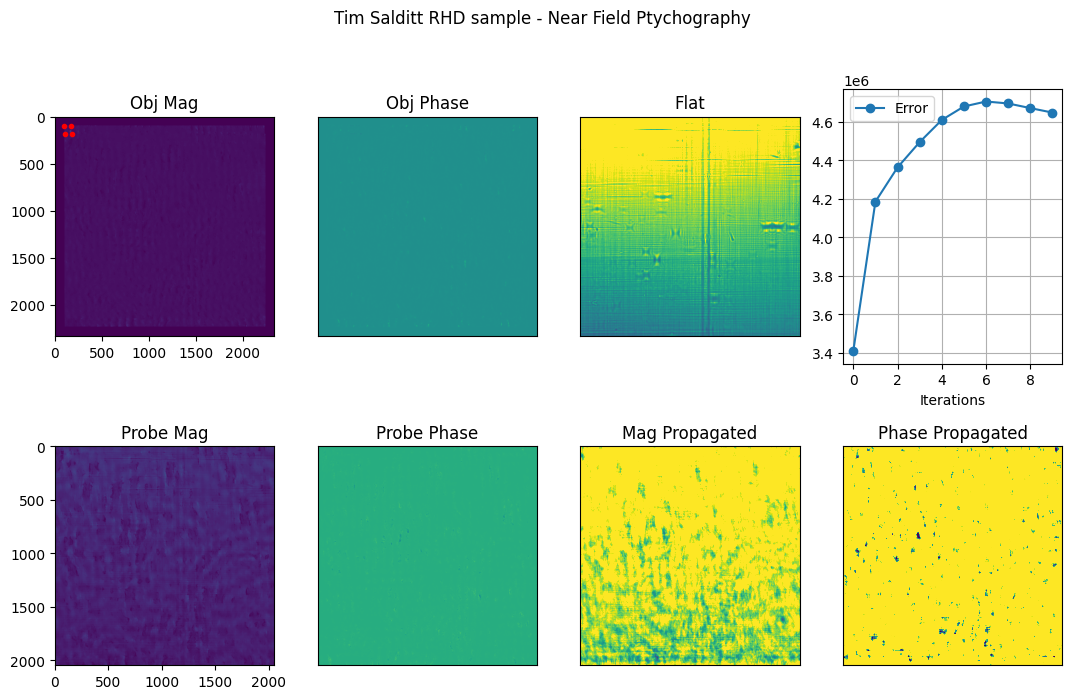

In [13]:
fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj)), ax[0,0].set_title('Obj Mag')
ax[0,0].plot(positions[:,0],positions[:,1],'.',color='r')
ax[0,1].imshow(np.angle(RAAR_obj)), ax[0,1].set_title('Obj Phase')
ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
ax[1,0].imshow(np.abs(RAAR_probes[0])), ax[1,0].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[1,2].imshow(np.abs(propagated_probe),vmax=0.5), ax[1,2].set_title('Mag Propagated')
ax[1,3].imshow(np.angle(propagated_probe),vmax=0.1,vmin=-0.1), ax[1,3].set_title('Phase Propagated')
ax[0,3].plot(RAAR_error,'o-',label='Error')
ax[0,3].set_xlabel('Iterations')
ax[0,3].legend(), ax[0,3].grid()

fig.suptitle('Tim Salditt RHD sample - Near Field Ptychography')

for i, ax in enumerate(ax.ravel()):
    if i==3 or i==0 or i ==4: continue
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots()
ax.plot(positions[:,1],positions[:,0],'o')

In [ ]:
# inputs["regularization_object"] = 0.25
# inputs["regularization_probe"] = 0.5
# inputs["step_object"] = 0.7
# inputs["step_probe"] = 0.5

# inputs["friction_object"] = 0.9
# inputs["friction_probe"] = 0.99
# inputs["momentum_counter"] = 10
# inputs["use_mPIE"] = False
# PIE_obj, PIE_probes, PIE_error = sscCdi.PIE_multiprobe_loop(DPs, positions,obj_guess,probe_guess,inputs)

# propagated_probe_PIE = sscCdi.fresnel_propagator_cone_beam(PIE_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],z2,z1) 
# propagated_probe_PIE /= np.max(propagated_probe_PIE)

# fig, ax = plt.subplots(2,4,figsize=(13,8),dpi=100)
# ax[0,0].imshow(np.abs(PIE_obj[0])), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,1],positions[:,0],'.',color='r')
# ax[0,1].imshow(np.angle(PIE_obj[0])), ax[0,1].set_title('Obj Phase')
# ax[0,2].imshow(np.abs(empty),vmax=6000), ax[0,2].set_title('Flat')
# ax[1,0].imshow(np.abs(PIE_probes[0])), ax[1,0].set_title('Probe Mag')
# ax[1,1].imshow(np.angle(PIE_probes[0])), ax[1,1].set_title('Probe Phase')
# ax[1,2].imshow(np.abs(propagated_probe_PIE),vmax=0.5), ax[1,2].set_title('Mag Propagated')
# ax[1,3].imshow(np.angle(propagated_probe_PIE),vmax=0.1,vmin=-0.1), ax[1,3].set_title('Phase Propagated')
# ax[0,3].plot(PIE_error,'o-',label='Error')
# ax[0,3].set_xlabel('Iterations')
# ax[0,3].legend(), ax[0,3].grid()

# fig.suptitle('Tim Salditt RHD sample - Near Field Ptychography')

# for i, ax in enumerate(ax.ravel()):
#     if i==3 or i==0 or i ==4: continue
#     ax.set_xticks([])
#     ax.set_yticks([])